In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils

In [2]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [3]:
_SYMBOL = 'KO'
_DATE = '2020-04-02'

In [4]:
query = f"""
    select *
    from td.equities
    where symbol = '{_SYMBOL}'
        and market_datetime::date = '{_DATE}'
    limit 10
    """
stocks = utils.query_db(query=query)
stocks.head(3).T

,0
symbol,KO
open,42.22
high,44.19
low,41.8623
close,43.95
volume,1.76219e+07
market_datetime_epoch,1585803600000.0
empty,False
market_datetime,2020-04-02 05:00:00
file_datetime,2020-04-19 00:09:51


In [5]:
query = f"""
    with raw as (
        select *, dense_rank() over(partition by symbol order by file_datetime desc) as dr
        from td.options_detail
        where file_datetime::date = '{_DATE}' and symbol = '{_SYMBOL}'
        )
    select
        symbol
        , put_call
        , put_call = 'CALL' as is_call
        , description
        , bid
        , ask
        , last
        , close_price
        , total_volume
        , open_interest
        , strike
        , days_to_expiration
        , expiration_date_from_epoch::date
        , file_datetime::date
    from raw
    where dr = 1
    order by put_call, days_to_expiration, strike
    """
options = utils.query_db(query=query)
options.head(3).T

,0,1,2
symbol,KO,KO,KO
put_call,CALL,CALL,CALL
is_call,True,True,True
description,KO Apr 3 2020 25 Call (Weekly),KO Apr 3 2020 30 Call (Weekly),KO Apr 3 2020 35 Call (Weekly)
bid,14.5,9.5,4
ask,19.5,14.5,7.6
last,17.4,13.15,7.1
close_price,19.25,14.25,9.25
total_volume,7,0,2
open_interest,1,8,22


### Put call parity

In [6]:
# call and put cols
_options = options.copy()
_options['call_ask'] = _options.apply(lambda x: x['ask'] if x['is_call'] else 0, axis=1)
_options['put_ask'] = _options.apply(lambda x: x['ask'] if not x['is_call'] else 0, axis=1)

In [7]:
# parity
_groups = ['symbol', 'strike', 'days_to_expiration', 'expiration_date_from_epoch']
_aggs = {'call_ask': 'max', 'put_ask': 'max'}
parity = _options.groupby(_groups).agg(_aggs)

parity['forward'] = parity['call_ask'] - parity['put_ask']
parity['cumulative_premium'] = parity['call_ask'] + parity['put_ask']
parity = parity.reset_index()

_numerator = -np.log((parity['put_ask'] + stocks['open'].values - parity['call_ask'])/parity['strike'])
parity['r'] = _numerator/(parity['days_to_expiration']/252)

# break even
parity['call_break_even'] = parity['call_ask'] + parity['strike']
parity['put_break_even'] = parity['strike'] - parity['put_ask']
parity['call_distance'] = parity['call_break_even'] - stocks['open'].values
parity['put_distance'] = stocks['open'].values - parity['put_break_even']

parity['percent_call_distance'] = parity['call_distance']/stocks['open'].values
parity['_forward'] = parity['forward'] + parity['strike']

parity.head()

,symbol,strike,days_to_expiration,expiration_date_from_epoch,call_ask,put_ask,forward,cumulative_premium,r,call_break_even,put_break_even,call_distance,put_distance,percent_call_distance,_forward
0,KO,20.0,16.0,2020-04-17,24.50,0.09,24.41,24.59,1.826562,44.50,19.91,2.28,22.31,0.054003,44.41
1,KO,20.0,23.0,2020-04-24,24.50,0.05,24.45,24.55,1.295287,44.50,19.95,2.28,22.27,0.054003,44.45
2,KO,20.0,44.0,2020-05-15,24.15,0.37,23.78,24.52,0.465112,44.15,19.63,1.93,22.59,0.045713,43.78
3,KO,20.0,79.0,2020-06-19,23.90,0.66,23.24,24.56,0.166979,43.90,19.34,1.68,22.88,0.039792,43.24
4,KO,20.0,142.0,2020-08-21,23.55,0.33,23.22,23.88,0.091028,43.55,19.67,1.33,22.55,0.031502,43.22


In [8]:
def plot(title, x, y, vline=None, ymin=None, ymax=None, hline=None, xmin=None, xmax=None):
    plt.title(title)
    plt.plot(x, y)
    if vline is not None:
        plt.vlines(
            vline,
            ymin=ymin,
            ymax=ymax,
            colors='r',
            linestyles='dotted'
        )
    if hline is not None:
        plt.hlines(
            hline,
            xmin=xmin,
            xmax=xmax,
            colors='r',
            linestyles='dotted'
        )
    plt.show()

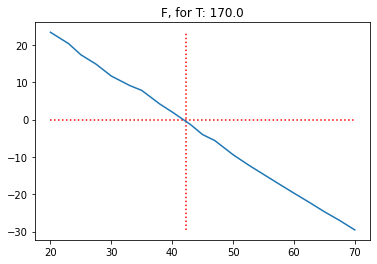

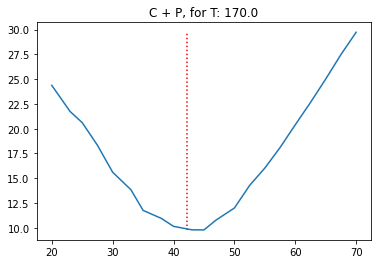

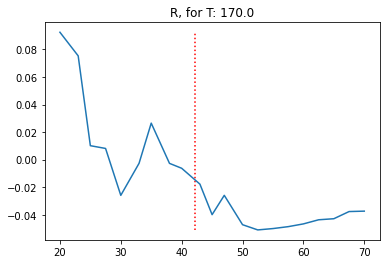

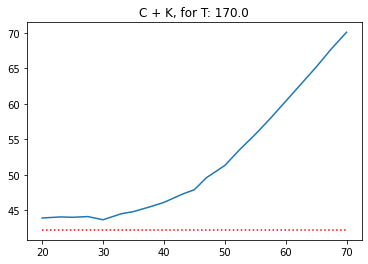

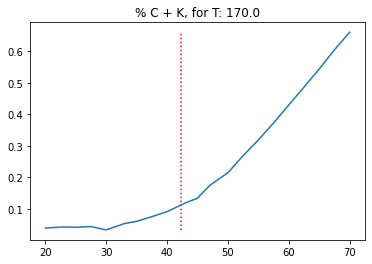

In [9]:
_N_EXPIRATION = 9
_expiration = np.sort(parity['days_to_expiration'].unique())[_N_EXPIRATION]
_s = parity[parity['days_to_expiration'] == _expiration]

plot(
    title=f'F, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['forward'],
    vline=stocks['open'],
    ymin=_s['forward'].min(),
    ymax=_s['forward'].max(),
    hline=0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
)

plot(
    title=f'C + P, for T: {_expiration}',
    x=_s['strike'],
    y=_s['cumulative_premium'],
    vline=stocks['open'],
    ymin=_s['cumulative_premium'].min(),
    ymax=_s['cumulative_premium'].max()
)

plot(
    title=f'R, for T: {_expiration}',
    x=_s['strike'],
    y=_s['r'],
    vline=stocks['open'],
    ymin=_s['r'].min(),
    ymax=_s['r'].max()
)

plot(
    title=f'C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['call_break_even'],
    hline=stocks['open'],
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max()
)

plot(
    title=f'% C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['percent_call_distance'],
    vline=stocks['open'],
    ymin=_s['percent_call_distance'].min(),
    ymax=_s['percent_call_distance'].max()
)


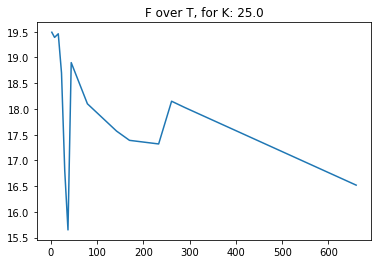

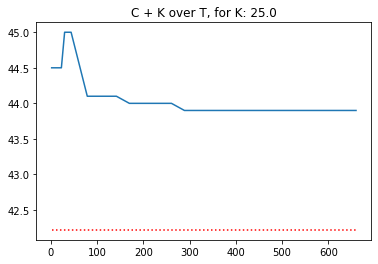

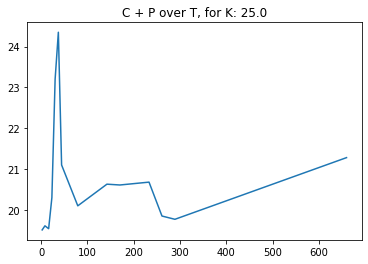

In [10]:
_N_STRIKE = 3
_strike = np.sort(parity['strike'].unique())[_N_STRIKE]
_e = parity[parity['strike'] == _strike]

plot(
    title=f'F over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['forward']
)

plot(
    title=f'C + K over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['call_break_even'],
    hline=stocks['open'],
    xmin=_e['days_to_expiration'].min(),
    xmax=_e['days_to_expiration'].max()
)

plot(
    title=f'C + P over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['cumulative_premium']
)